In [ ]:
print('Spaghetti!')

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

!python --version
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

print(tf.reduce_sum(tf.random.normal([1000, 1000])))

Spaghetti!
Python 3.8.0
Num GPUs Available 1
tf.Tensor(413.88147, shape=(), dtype=float32)


In [2]:
#####################################################
# Load the training images
#####################################################

# Load the training images and class labels
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

IMG_SIZE = 299  # VGG16 224, InceptionV3 299
BATCH_SIZE = 16
EPOCHS = 20

# Classes which should be removed from the training set
REMOVE_LABELS = ['20'] #['28', '55'] # 28 doesn't help, 20 does help

# Filter for a subset of labels in the images to load
FILTER_LABEL = []

QUICK_DIRTY = False
if QUICK_DIRTY:
    IMG_SIZE = 112
    BATCH_SIZE = 40
    EPOCHS = 10
    FILTER_LABEL = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Local data directories
DATA_DIR = 'D:/deeplearning/AML_Foodrecognition'
TRAIN_DIR = DATA_DIR + '/train_set/'
TEST_DIR = DATA_DIR + '/test_set/'
MODEL_DIR = DATA_DIR + '/models/'

# Maximum number of images to load (there are 30k), set to 0 for all
MAX_IMAGE = 0

# Load all the training labels
train_labels = pd.read_csv(DATA_DIR + '/train_labels.csv', dtype={'label': object})
if (len(FILTER_LABEL) > 0):
    train_labels = train_labels[train_labels['label'].isin(FILTER_LABEL)].copy().reset_index()

# Remove bad classes from the training data
count = len(train_labels)
train_labels = train_labels[~train_labels['label'].isin(REMOVE_LABELS)]
print('Removed {} bad training samples'.format(count - len(train_labels)))
NUM_CLASSES = len(train_labels.groupby('label').count())

# Remove images with text from the training data
images_with_text = pd.read_csv('./images_with_text.csv')
count = len(train_labels)
#train_labels = train_labels[~train_labels['img_name'].isin(images_with_text['img_name'])]
print('Removed {} training samples with text'.format(count - len(train_labels)))
NUM_CLASSES = len(train_labels.groupby('label').count())

# Remove all detected non-food training images from the training data
images_with_text = pd.read_csv('./non_food_training_images-2.csv')
count = len(train_labels)
#train_labels = train_labels[~train_labels['img_name'].isin(images_with_text['img_name'])]
print('Removed {} non-food training samples'.format(count - len(train_labels)))
NUM_CLASSES = len(train_labels.groupby('label').count())

# Remove manually filtered images
images_with_text = pd.read_csv('./manual_cleanup.csv')
count = len(train_labels)
train_labels = train_labels[~train_labels['img_name'].isin(images_with_text['img_name'])]
print('Removed {} manually filtered training samples'.format(count - len(train_labels)))
NUM_CLASSES = len(train_labels.groupby('label').count())

# Shuffle the training labels
#train_labels = shuffle(train_labels, random_state=3422545) # Current top score
train_labels = shuffle(train_labels, random_state=563456) # Current top score

print('{} training labels loaded'.format(len(train_labels)))  

Removed 27 bad training samples
Removed 0 training samples with text
Removed 0 non-food training samples
Removed 204 manually filtered training samples
30381 training labels loaded


In [5]:
#####################################################
# Create the data generators
#####################################################

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import datetime
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Create a training and test set generator
train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.0,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_split = int(len(train_labels)*0.85)
train_dataframe = train_labels[:train_split][['img_name','label']]
val_dataframe = train_labels[train_split:][['img_name','label']]

train_generator = train_datagen.flow_from_dataframe(
    train_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False)

# Early stopping callback, stops the training if there's no more progress
early_stopping = EarlyStopping(
    monitor='val_acc', 
    patience=3, 
    min_delta=0.001, 
    mode='max'
)

# Learning rate scheduler callback, decreases the LR during training
def lr_scheduler(epoch, lr):
    if epoch == 3:
        lr = lr/10       # After 3 epochs, divide by 10
    
    if epoch == 6:
        return lr/10

    if epoch == 10:
        return lr/10

    if epoch == 15:
        return lr/10

    return lr

lr_scheduler_callback = LearningRateScheduler(
    lr_scheduler
)

# Model checkpoint callback, stores the model every few epochs during training
model_checkpoint_callback = ModelCheckpoint(
    MODEL_DIR + 'model_checkpoint',
    monitor="val_acc",
    verbose=1,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

def plot_hist(hist):
    plt.plot(hist.history["acc"])
    plt.plot(hist.history["val_acc"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Found 25823 validated image filenames belonging to 79 classes.
Found 4558 validated image filenames belonging to 79 classes.
Found 7653 images belonging to 1 classes.


In [200]:
##################################################
# Train Xception model
##################################################

run_name = input('Name this run')

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Define Tensorboard callback with dedicated log directory
log_dir = "logs/fit/" + run_name + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, update_freq=1)

def InitializeXceptionModel():
    # Defining the pretrained base model
    base = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    # On more dense layers + dropout, didn't improve at all
    #x = Dense(512, activation="relu")(x) # Adding dense 512 + dropout lowered to 59%
    #x = Dropout(0.2)(x)
    #x = Dense(256, activation="relu")(x)
    # Defining the head of the model where the prediction is conducted
    head = Dense(NUM_CLASSES, activation='softmax')(x)
    # Combining base and head 
    model = Model(inputs=base.input, outputs=head)

    return model

if 'model' in locals() or 'model' in globals():
    if input('Train a fresh model?') == 'y':
        print('Discarding current model')
        model = InitializeXceptionModel()
else:
    model = InitializeXceptionModel()

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['acc'])

hist = model.fit(
    train_generator, 
    epochs=EPOCHS, 
    #steps_per_epoch=int(len(train_dataframe)/BATCH_SIZE/2), 
    validation_data=val_generator, 
    #validation_steps=int(len(val_dataframe)/BATCH_SIZE/2),
    verbose=1,
    #class_weight = class_weights_dict,
    callbacks=[tb_callback, lr_scheduler_callback, model_checkpoint_callback])#, early_stopping])

plot_hist(hist)

Discarding current model


C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
1614/1614 [==============================] - ETA: 0s - loss: 2.2301 - acc: 0.4703
Epoch 00001: saving model to D:/deeplearning/AML_Foodrecognition/models\model_checkpoint
INFO:tensorflow:Assets written to: D:/deeplearning/AML_Foodrecognition/models\model_checkpoint\assets
1614/1614 [==============================] - 679s 418ms/step - loss: 2.2301 - acc: 0.4703 - val_loss: 1.4699 - val_acc: 0.6169 - lr: 1.0000e-04


C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/20
1614/1614 [==============================] - ETA: 0s - loss: 1.2524 - acc: 0.6778
Epoch 00002: saving model to D:/deeplearning/AML_Foodrecognition/models\model_checkpoint
INFO:tensorflow:Assets written to: D:/deeplearning/AML_Foodrecognition/models\model_checkpoint\assets
1614/1614 [==============================] - 760s 471ms/step - loss: 1.2524 - acc: 0.6778 - val_loss: 1.3220 - val_acc: 0.6604 - lr: 1.0000e-04


C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/20
1614/1614 [==============================] - ETA: 0s - loss: 0.8816 - acc: 0.7652
Epoch 00003: saving model to D:/deeplearning/AML_Foodrecognition/models\model_checkpoint
INFO:tensorflow:Assets written to: D:/deeplearning/AML_Foodrecognition/models\model_checkpoint\assets
1614/1614 [==============================] - 707s 438ms/step - loss: 0.8816 - acc: 0.7652 - val_loss: 1.3467 - val_acc: 0.6619 - lr: 1.0000e-04


C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/20
1614/1614 [==============================] - ETA: 0s - loss: 0.5097 - acc: 0.8720
Epoch 00004: saving model to D:/deeplearning/AML_Foodrecognition/models\model_checkpoint
INFO:tensorflow:Assets written to: D:/deeplearning/AML_Foodrecognition/models\model_checkpoint\assets
1614/1614 [==============================] - 664s 411ms/step - loss: 0.5097 - acc: 0.8720 - val_loss: 1.2036 - val_acc: 0.6975 - lr: 1.0000e-05


C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5/20
1614/1614 [==============================] - ETA: 0s - loss: 0.4316 - acc: 0.8929
Epoch 00005: saving model to D:/deeplearning/AML_Foodrecognition/models\model_checkpoint
INFO:tensorflow:Assets written to: D:/deeplearning/AML_Foodrecognition/models\model_checkpoint\assets
1614/1614 [==============================] - 679s 420ms/step - loss: 0.4316 - acc: 0.8929 - val_loss: 1.2103 - val_acc: 0.6955 - lr: 1.0000e-05


C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 6/20
 764/1614 [=============>................] - ETA: 5:33 - loss: 0.3723 - acc: 0.9124

KeyboardInterrupt: 

In [202]:
#######################################################
#  Save the model
#######################################################

# TODO: model name in filename
model.save(MODEL_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + 
    'model.' + 'xception' +
    '.' + str(NUM_CLASSES) + 'c.' +
    str(IMG_SIZE) + 'px' + run_name + '.69p')

INFO:tensorflow:Assets written to: D:/deeplearning/AML_Foodrecognition/models/20211217-180516model.xception.79c.299pxxvalidation-ensemble-model3.69p\assets


C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\seth\anaconda3\envs\tf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [3]:
#######################################################
#  Load a model
#######################################################
from tensorflow.keras import models

#model = models.load_model(MODEL_DIR + 'model_checkpoint')
#model = models.load_model(MODEL_DIR + '20211217-093240model.xception.79c.299pxmanual-filter-4-classes')
model1 = models.load_model(MODEL_DIR + '20211215-162121model.xception.79c.299px.69p-removed-class-20 GOOD')
model2 = models.load_model(MODEL_DIR + '20211217-132047model.xception.79c.299pxclass-weights-retry.68p GOOD')
model3 = models.load_model(MODEL_DIR + '20211217-180516model.xception.79c.299pxxvalidation-ensemble-model3.69p GOOD')

In [203]:
model1 = model
model2 = model

In [7]:
#######################################################
#  Classify the test set
#######################################################

# Classify
test_generator.reset()
probabilities1 = model1.predict(test_generator, verbose=1)
probabilities2 = model2.predict(test_generator, verbose=1)
probabilities3 = model3.predict(test_generator, verbose=1)
filenames = test_generator.filenames.copy()
for i in range(0,len(filenames)):
    filenames[i] = filenames[i][filenames[i].rfind('\\')+1:]

probabilities = (probabilities1*1/3) + (probabilities2*1/3) + (probabilities3*1/3)
predicted_class_indices = np.argmax(probabilities, axis=-1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Create the pandas DataFrame
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})

results.to_csv(DATA_DIR + '/predictions.csv', index=False)
results

479/479 [==============================] - 36s 76ms/step


,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,34
3,test_1000.jpg,29
4,test_1001.jpg,32
...,...,...
7648,test_995.jpg,39
7649,test_996.jpg,74
7650,test_997.jpg,69
7651,test_998.jpg,60


test_1002.jpg


<AxesSubplot:>

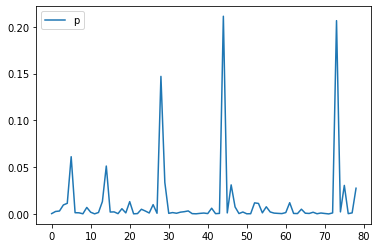

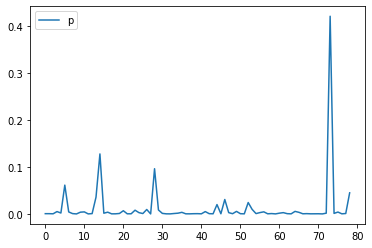

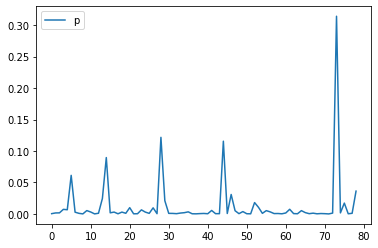

In [64]:
i = 5
print(results['img_name'][i])
probabilities = (probabilities1/2) + (probabilities2/2)
probabilities[0]
p=pd.DataFrame({"p": probabilities1[i]})
p.plot()
p=pd.DataFrame({"p": probabilities2[i]})
p.plot()
p=pd.DataFrame({"p": probabilities[i]})
p.plot()

In [ ]:
#######################################################
#  Look for confusing training images
#######################################################

train_set_datagen = ImageDataGenerator(rescale=1./255)

train_set_generator = train_set_datagen.flow_from_dataframe(
    train_labels,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=100,
    class_mode='categorical',
    shuffle=False
)

# Classify
train_set_generator.reset()
#probabilities = model.predict(train_set_generator, batch_size=32, verbose=1, steps=10, workers=2)
probabilities = model.predict(train_set_generator, verbose=1, workers=2)

In [ ]:
#######################################################
#  Display the confusing training images
#######################################################

from PIL import Image
fig, axs = plt.subplots(ncols=2, nrows=8)
fig.set_size_inches(15, 30)

# Show images that were hard to classify
confidence_threshold = 0.3

filenames = pd.DataFrame({'filename':train_set_generator.filenames.copy()})
hard_images = filenames[np.max(probabilities, axis=1) < confidence_threshold]
print('Found {} confusing training images at a {} confidence threshold'.format(len(hard_images), confidence_threshold))

row = 0
for idx in hard_images.sample(frac=1).index:
    # Load image
    img = Image.open(TRAIN_DIR + hard_images.loc[idx]['filename'])

    # Plot image    
    axs[row, 0].imshow(img)
    #axs[row, 0].set_title('Class: ' + hard_images.loc[idx]['label'])

    # Plot probabilities
    axs[row, 1].plot(probabilities[idx])
    axs[row, 1].set_title('Max:' + str(max(probabilities[idx])))

    #print(label)
    print(hard_images['filename'][idx])

    row += 1
    if row > 7:
        break

In [ ]:
#######################################################
#  Confusion matrix
#######################################################
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.pyplot import figure

val_generator.reset()

# Get the ground truth
filenames = val_generator.filenames.copy()
labels = val_generator.labels.copy()

# Predict classes
probabilities = model.predict(val_generator, verbose=1, workers=2)
predictions = np.argmax(probabilities, axis=-1)

# Ground truth
truth_label_indices = val_generator.labels.copy()

# Map indices to class
label_dict = (train_generator.class_indices)
label_dict = dict((v,k) for k,v in label_dict.items())
y_pred = [label_dict[k] for k in predictions]
y_truth = [label_dict[k] for k in truth_label_indices]

df_cm = pd.DataFrame({
    'img_name': filenames,
    'label_truth': y_truth,
    'label_predict': y_pred
    })

fig, ax = plt.subplots(figsize=(40,40))
cm = confusion_matrix(y_truth, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)

In [ ]:
#######################################################
# Show the images of each class to debug bad training
# images
#######################################################

NCOL = 5
NROW = 32

from PIL import Image
fig, axs = plt.subplots(ncols=NCOL, nrows=NROW)
fig.set_size_inches(20, 120)

label = '12'
df = train_labels[train_labels['label'] == label].sample(frac=1)
print('Found {} images for class {}'.format(len(df), label))

i = 0
for row in range(0, NROW):
    if i > len(df):
        print('No more images')
        break

    for col in range(0, NCOL):
        # Load image
        img = Image.open(TRAIN_DIR + df.iloc[i]['img_name'])

        # Plot image    
        axs[row, col].imshow(img)
        axs[row, col].xaxis.set_visible(False)
        axs[row, col].yaxis.set_visible(False)
        axs[row, col].set_title('Class: ' + df.iloc[i]['img_name'])

        i += 1

In [40]:
#######################################################
#  Check which classes have the most problems - part 1
#######################################################

# Predict classes
val_generator.reset()
probabilities = model.predict(val_generator, verbose=1)
predicted_label_indices = np.argmax(probabilities, axis=-1)

# Get the ground truth
filenames = val_generator.filenames.copy()
truth_label_indices = val_generator.labels.copy()

label_dict = (train_generator.class_indices)
label_dict = dict((v,k) for k,v in label_dict.items())
y_pred = [label_dict[k] for k in predicted_label_indices]
y_truth = [label_dict[k] for k in truth_label_indices]

285/285 [==============================] - 21s 74ms/step


In [ ]:
#######################################################
#  Check which classes have the most problems - part 2
#######################################################
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_truth, y_pred)
# precision tp / (tp + fp)
precision = precision_score(y_truth, y_pred, average=None)
# recall: tp / (tp + fn)
recall = recall_score(y_truth, y_pred, average=None)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_truth, y_pred, average=None)
print('F1 score: ' % f1)

pd.set_option('display.max_rows', 500)

df_cm = pd.DataFrame({
    'img_name': filenames,
    'label_truth': y_truth,
    'label_predict': y_pred
    })
    
df_cm['correct'] = False
df_cm.loc[df_cm['label_truth'] == df_cm['label_predict'], 'correct'] = True
print(len(df_cm[df_cm['correct'] == True]))
print(len(df_cm[df_cm['correct'] == False]))

plt.figure(figsize=(15, 10))
class_report_mean = df_cm.groupby('label_truth').mean()['correct']
class_report_count = df_cm.groupby('label_truth').count()['img_name']
#class_report.plot()
class_report = pd.DataFrame({
    'count': class_report_count,
    'correct': class_report_mean
    })
class_report.sort_values('correct', inplace=True)
class_report['correct'].plot()

#class_report[10:]

In [ ]:
#######################################################
#  Create class weights for training, part 3
#######################################################

from sklearn.metrics import classification_report
    
cr = classification_report(y_truth, y_pred, output_dict=True)

cr_d = pd.DataFrame.from_dict(cr).T[['precision', 'recall', 'f1-score']]

cr_d['label'] = cr_d.index
#cr_d.plot()
df = cr_d.merge(class_report, left_on='label', right_on='label_truth')

# Convert class report into class weighting
class_weights = df[['label', 'f1-score']].copy()

f1min = min(class_weights['f1-score'])
f1max = max(class_weights['f1-score'])
f1spread = f1max - f1min

class_weights['weight'] = f1max - (class_weights['f1-score'] - f1min) #1/np.exp(class_weights['f1-score'])
class_weights = class_weights[['label', 'weight']]
class_weights.set_index('label', inplace=True)

class_weights_dict = {}
for label in class_weights.index:
    #class_weights_dict[label] = class_weights.loc[label] # Readable version
    class_weights_dict[train_generator.class_indices[label]] = class_weights.loc[label] # Trainable version

#print(class_weights_dict['12'])
#print(class_weights_dict['75'])
class_weights_dict

In [104]:
#####################################################
# Train basic network on ensemble of two models
#####################################################

# Classify the validation set
val_generator.reset()
labels = val_generator.labels.copy()

probabilities1 = model1.predict(val_generator, verbose=1)
probabilities2 = model2.predict(val_generator, verbose=1)

X = np.concatenate((probabilities1, probabilities2), axis=1)
y = labels

# One hot encode labels
y_arr = np.array(y)
shape = (y_arr.size, y_arr.max() + 1)
one_hot = np.zeros(shape)
rows = np.arange(y_arr.size)
one_hot[rows, y_arr] = 1

# Define the model
model_ensemble = Sequential()
model_ensemble.add(Dense(64, activation="relu", input_dim=NUM_CLASSES*2))
model_ensemble.add(Dense(NUM_CLASSES, activation="softmax"))
model_ensemble.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics = ['accuracy'])

# Train the model
history = model_ensemble.fit(X, one_hot, epochs=4)

acc = history.history['accuracy']
loss = history.history['loss']

print(acc)


285/285 [==============================] - 21s 74ms/step


TypeError: __init__() got multiple values for argument 'activation'

In [195]:
# Predict ensemble
X = np.concatenate((probabilities1, probabilities2), axis=1)
y_pred = model_ensemble.predict(X)

predicted_class_indices = np.argmax(y_pred, axis=-1)

labels = (val_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Create the pandas DataFrame
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})

results.to_csv(DATA_DIR + '/predictions.csv', index=False)
results

,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,34
3,test_1000.jpg,29
4,test_1001.jpg,32
...,...,...
7648,test_995.jpg,39
7649,test_996.jpg,74
7650,test_997.jpg,69
7651,test_998.jpg,60


<AxesSubplot:>

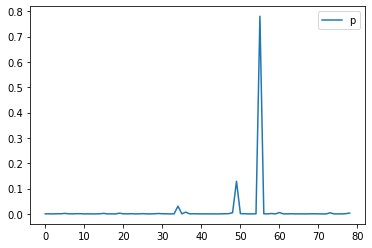

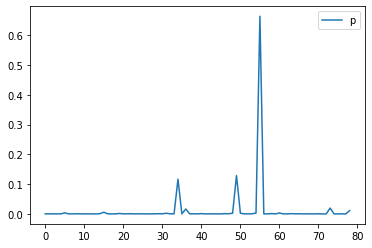

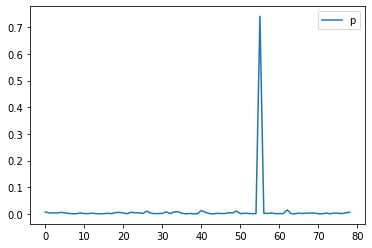

In [194]:
i = 6
p=pd.DataFrame({"p": probabilities1[i]})
p.plot()
p=pd.DataFrame({"p": probabilities2[i]})
p.plot()
p=pd.DataFrame({"p": y_pred[i]})
p.plot()